### Match model output to DFO CTD data and store in /data/eolson/results/MEOPAR/PARcalcs/DFO_CTD_withModelPAR.sqlite
- match PAR, CT, and SA
- if possible, also include phyto biomass and turbidity for k estimation

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw
import pickle
import matplotlib as mpl

import scipy.optimize as scopt
from sqlalchemy.types import DateTime

%matplotlib inline

In [2]:
# model output to match
flen=1
namfmt='nowcast'
filemap={'PAR':'carp_T','e3t':'carp_T','vosaline':'grid_T','votemper':'grid_T',
         'diatoms':'ptrc_T','flagellates':'ptrc_T','ciliates':'ptrc_T','Fraser_tracer':'turb_T'}
fdict={'carp_T':1,'grid_T':1,'turb_T':1,'ptrc_T':1}
PATH='/results/SalishSea/nowcast-green.201812/'
runID='HC201812'
dstart=dt.datetime(2015,1,1)
dend=dt.datetime(2015,3,1)
#dend=dt.datetime(2018,1,1)

In [3]:
dstart.year,dstart.month

(2015, 1)

In [34]:
basedir='/data/eolson/results/MEOPAR/PARcalcs/'
dbname='DFO_CTD_withModelPAR.sqlite'
datelims=()
engine = create_engine('sqlite:///' + basedir + dbname, echo = True)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)


2020-09-09 22:09:55,224 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-09-09 22:09:55,224 INFO sqlalchemy.engine.base.Engine ()
2020-09-09 22:09:55,225 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-09-09 22:09:55,225 INFO sqlalchemy.engine.base.Engine ()
2020-09-09 22:09:55,226 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2020-09-09 22:09:55,226 INFO sqlalchemy.engine.base.Engine ()
2020-09-09 22:09:55,229 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("CalcsTBL")
2020-09-09 22:09:55,230 INFO sqlalchemy.engine.base.Engine ()
2020-09-09 22:09:55,232 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'CalcsTBL' AND type = 'table'
2020-09-09 22:09:55,232 INFO sqlalchemy.engine.base.Engine ()
2020-09-09 22:09:55,233 INFO sqlalchemy.e

In [5]:
session.query(ObsTBL.PAR1_units).distinct().all()

[(None), ('uE/m^2/sec')]

In [6]:
session.query(ObsTBL.PAR_1_units).distinct().all()

[(None), ('uE/m^2/sec')]

In [7]:
PAR=case([(ObsTBL.PAR!=None, ObsTBL.PAR)], else_=
             case([(ObsTBL.PAR1!=None, ObsTBL.PAR1)], else_=ObsTBL.PAR_1))

In [8]:
SA=case([(CalcsTBL.Salinity_T0_C0_SA!=None, CalcsTBL.Salinity_T0_C0_SA)], else_=
         case([(CalcsTBL.Salinity_T1_C1_SA!=None, CalcsTBL.Salinity_T1_C1_SA)], else_=
         case([(CalcsTBL.Salinity_SA!=None, CalcsTBL.Salinity_SA)], else_= None)))
CT=case([(CalcsTBL.Temperature_Primary_CT!=None, CalcsTBL.Temperature_Primary_CT)], else_=
         case([(CalcsTBL.Temperature_Secondary_CT!=None, CalcsTBL.Temperature_Secondary_CT)], else_=CalcsTBL.Temperature_CT))
ZD=case([(ObsTBL.Depth!=None,ObsTBL.Depth)], else_= CalcsTBL.Z)

In [9]:
qry=session.query(StationTBL.ID.label('StationTBLID'),ObsTBL.ID.label('ObsTBLID'),
                  StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),StationTBL.Lat,StationTBL.Lon,
                ZD.label('Z'),PAR.label('PAR'),SA.label('SA'),CT.label('CT')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0,
                                            StationTBL.StartYear>=dstart.year,
                                            or_(StationTBL.StartYear>dstart.year,StationTBL.StartMonth>=dstart.month),
                                            StationTBL.StartYear<=dend.year,
                                            or_(StationTBL.StartYear<dend.year,StationTBL.StartMonth<=dend.month)))

In [10]:
df1=pd.DataFrame(qry.all())

In [11]:
df1['dtUTC']=[dt.datetime(int(y),int(m),int(d))+dt.timedelta(hours=h) \
              for y,m,d,h in zip(df1['Year'],df1['Month'],df1['Day'],df1['Hour'])]

In [12]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

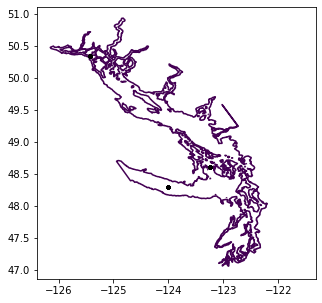

In [13]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(df1['Lon'],df1['Lat'],'k.')
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))

In [14]:
df1.head()

,StationTBLID,ObsTBLID,Year,Month,Day,Hour,Lat,Lon,Z,PAR,SA,CT,dtUTC
0,1001,329162,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,1.983099,0.2,29.849611,8.942753,2015-02-11 05:17:46
1,1001,329163,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,2.974641,0.1,29.852177,8.942511,2015-02-11 05:17:46
2,1001,329164,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,3.966178,0.1,29.869012,8.941135,2015-02-11 05:17:46
3,1001,329165,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,4.957711,0.0,29.915690,8.936661,2015-02-11 05:17:46
4,1001,329166,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,5.949239,0.0,29.913935,8.936489,2015-02-11 05:17:46


In [15]:
df1.tail()

,StationTBLID,ObsTBLID,Year,Month,Day,Hour,Lat,Lon,Z,PAR,SA,CT,dtUTC
719,1048,366988,2015.0,3.0,6.0,15.276944,50.346333,-125.431167,324.920261,0.0,29.553424,8.873814,2015-03-06 15:16:37
720,1048,366989,2015.0,3.0,6.0,15.276944,50.346333,-125.431167,325.910085,0.0,29.553848,8.873804,2015-03-06 15:16:37
721,1048,366990,2015.0,3.0,6.0,15.276944,50.346333,-125.431167,326.899904,0.0,29.555076,8.873782,2015-03-06 15:16:37
722,1048,366991,2015.0,3.0,6.0,15.276944,50.346333,-125.431167,327.889718,0.0,29.557912,8.873733,2015-03-06 15:16:37
723,1048,366992,2015.0,3.0,6.0,15.276944,50.346333,-125.431167,328.879528,0.0,29.567079,8.873580,2015-03-06 15:16:37


In [16]:
len(df1)

724

In [17]:
# do matches with vvl considered
data=et.matchData(df1,filemap,fdict,dstart,dend,namfmt,PATH,flen,method='vvlBin')

ftype=turb_T, are you sure? (if yes, add to list)


In [18]:
len(data)

394

In [19]:
data

,StationTBLID,ObsTBLID,Year,Month,Day,Hour,Lat,Lon,Z,PAR,...,mod_e3t,mod_vosaline,mod_votemper,mod_diatoms,mod_flagellates,mod_ciliates,mod_Fraser_tracer,k,indf,ih
0,1001,329162,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,1.983099,0.2,...,1.001261,29.437077,9.076343,0.019336,0.567340,0.183511,0.344172,1,41,5
1,1001,329163,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,2.974641,0.1,...,1.001268,29.539558,9.086275,0.017971,0.540466,0.173577,0.340101,2,41,5
2,1001,329164,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,3.966178,0.1,...,1.001283,29.665234,9.094213,0.016695,0.516796,0.164169,0.336009,3,41,5
3,1001,329165,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,4.957711,0.0,...,1.001312,29.739351,9.096522,0.015585,0.497693,0.156887,0.333047,4,41,5
4,1001,329166,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,5.949239,0.0,...,1.001367,29.781431,9.099732,0.015111,0.489840,0.154013,0.331413,5,41,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,1002,329551,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,173.453346,0.0,...,26.388119,33.226562,9.245314,0.001026,0.023443,0.004493,0.199347,29,41,11
390,1002,329552,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,174.444086,0.0,...,26.388119,33.226562,9.245314,0.001026,0.023443,0.004493,0.199347,29,41,11
391,1002,329553,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,175.434821,0.0,...,26.388119,33.226562,9.245314,0.001026,0.023443,0.004493,0.199347,29,41,11
392,1002,329554,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,176.425551,0.0,...,26.388119,33.226562,9.245314,0.001026,0.023443,0.004493,0.199347,29,41,11


In [20]:
data.keys()

Index(['StationTBLID', 'ObsTBLID', 'Year', 'Month', 'Day', 'Hour', 'Lat',
       'Lon', 'Z', 'PAR', 'SA', 'CT', 'dtUTC', 'j', 'i', 'mod_PAR', 'mod_e3t',
       'mod_vosaline', 'mod_votemper', 'mod_diatoms', 'mod_flagellates',
       'mod_ciliates', 'mod_Fraser_tracer', 'k', 'indf', 'ih'],
      dtype='object')

In [21]:
data2=data.loc[:,['StationTBLID', 'ObsTBLID','Z', 'PAR', 'SA', 'CT', 'dtUTC', 'i','j','k', 'mod_PAR', 'mod_e3t',
       'mod_vosaline', 'mod_votemper', 'mod_diatoms', 'mod_flagellates','mod_ciliates', 'mod_Fraser_tracer']]

In [29]:
data2.to_sql(
    runID+'_matchTBL',
    engine,
    if_exists='replace',
    index=False,
    chunksize=500,
    dtype={
        'StationTBLID': Integer, 
        'ObsTBLID': Integer,
        'Z':Float, 
        'PAR':Float,  
        'SA':Float, 
        'CT':Float, 
        'dtUTC':DateTime, 
        'i':Integer,'j':Integer,'k':Integer, 
        'mod_PAR':Float, 
        'mod_e3t':Float,
       'mod_vosaline':Float, 'mod_votemper':Float, 'mod_diatoms':Float, 'mod_flagellates':Float,
        'mod_ciliates':Float, 'mod_Fraser_tracer':Float
    }
)

In [30]:
session.commit()

In [35]:
session.close()

In [36]:
engine.dispose()

In [37]:
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
HC201812TBL=Base.classes.HC201812_matchTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

AttributeError: HC201812_matchTBL

In [27]:
Base.classes.

TypeError: 'Properties' object is not callable

In [48]:
data

,StationTBLID,ObsTBLID,Year,Month,Day,Hour,Lat,Lon,Z,PAR,...,mod_PAR,mod_e3t,mod_vosaline,mod_votemper,mod_diatoms,mod_flagellates,mod_ciliates,mod_Fraser_tracer,indf,ih
0,1001,329162,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,1.983099,0.2,...,NaN,NaN,29.486330,9.081116,0.018680,0.554424,0.178737,0.342215,41,5
1,1001,329163,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,2.974641,0.1,...,NaN,NaN,29.598737,9.090013,0.017370,0.529320,0.169147,0.338174,41,5
2,1001,329164,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,3.966178,0.1,...,NaN,NaN,29.699413,9.095278,0.016183,0.507987,0.160811,0.334643,41,5
3,1001,329165,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,4.957711,0.0,...,NaN,NaN,29.758345,9.097971,0.015371,0.494149,0.155590,0.332309,41,5
4,1001,329166,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,5.949239,0.0,...,NaN,NaN,29.796489,9.101224,0.014928,0.486913,0.152812,0.330827,41,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,1002,329551,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,173.453346,0.0,...,NaN,NaN,33.224970,9.246059,0.001032,0.023613,0.004529,0.199370,41,11
390,1002,329552,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,174.444086,0.0,...,NaN,NaN,33.226562,9.245314,0.001026,0.023443,0.004493,0.199347,41,11
391,1002,329553,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,175.434821,0.0,...,NaN,NaN,33.226562,9.245314,0.001026,0.023443,0.004493,0.199347,41,11
392,1002,329554,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,176.425551,0.0,...,NaN,NaN,33.226562,9.245314,0.001026,0.023443,0.004493,0.199347,41,11


In [24]:
data.keys()

Index(['StationTBLID', 'ObsTBLID', 'Year', 'Month', 'Day', 'Hour', 'Lat',
       'Lon', 'Z', 'PAR', 'SA', 'CT', 'dtUTC', 'j', 'i', 'mod_PAR', 'mod_e3t',
       'mod_vosaline', 'mod_votemper', 'mod_diatoms', 'mod_flagellates',
       'mod_ciliates', 'mod_Fraser_tracer', 'indf', 'ih'],
      dtype='object')

In [20]:
data.drop(data[data.k<0].index,inplace=True)

AttributeError: 'DataFrame' object has no attribute 'k'

In [27]:
np.shape(tmask)

(40, 898, 398)

In [36]:
fe3t=nc.Dataset('/results/SalishSea/nowcast-green.201812/01jan15/SalishSea_1h_20150101_20150101_carp_T.nc')
e3t=fe3t.variables['e3t'][5,:,500,300][tmask[:,500,300]==1]
zl=np.zeros((len(e3t),2))
zl[1:,0]=np.cumsum(e3t[:-1])
zl[:,1]=np.cumsum(e3t)


In [41]:
ik=[iii for iii,hhh in enumerate(zl) if hhh[1]>5.1][0] 

In [42]:
ik

6

In [43]:
zl

array([[0.        , 0.8422091 ],
       [0.8422091 , 1.68442142],
       [1.68442142, 2.52663994],
       [2.52663994, 3.36887097],
       [3.36887097, 4.21112585],
       [4.21112585, 5.0534277 ],
       [5.0534277 , 5.89582062],
       [5.89582062, 6.73839092],
       [6.73839092, 7.58130693],
       [7.58130693, 8.42489624],
       [8.42489624, 9.26979733]])

In [32]:
fe3t.variables['e3t']

<class 'netCDF4._netCDF4.Variable'>
float32 e3t(time_counter, deptht, y, x)
    standard_name: cell_thickness
    long_name: T-cell thickness
    units: m
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 h
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered deptht nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (24, 40, 898, 398)
filling on

In [ ]:
plt.plot(data['mod_PAR'],data['PAR'],'k.',ms=1)

In [ ]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
xx=data.loc[ii,['mod_PAR']].values
yy=data.loc[ii,['PAR']].values
ax.hist2d(xx[:,0],yy[:,0],bins=100,cmin=0,cmax=50);

In [ ]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii,['mod_PAR']].values
xx=data.loc[ii,['PAR']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison: HC201812')

In [ ]:
data.keys()

In [ ]:
stas=data.groupby(by=['Year','Month','Day','Lat','Lon'])

In [ ]:
stas

In [ ]:
with nc.Dataset('/results/SalishSea/nowcast-green.201812/01jan16/SalishSea_1h_20160101_20160101_ptrc_T.nc') as ftemp:
    deptht=ftemp.variables['deptht'][:]

In [ ]:
deptht[5]

In [ ]:
data['mod_Z']=[deptht[ii] for ii in data['k']]

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(data['Z'],data['mod_Z'],'k.',ms=1)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')

In [ ]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<10
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison Upper 10m: HC201812')

In [ ]:
plt.hist(yz-xz)
plt.title('hist: model z - obs z')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(yz-xz,np.log10(yy[:,0]+1)-np.log10(xx[:,0]+1),'k.',ms=1)
ax.set_xlabel('Model Z - Obs Z')
ax.set_ylabel('log10(model PAR +1)-log10(obs PAR +1)')

In [ ]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<2
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison Upper 2m: HC201812')

In [ ]:
data.keys()

In [ ]:
temp=data.loc[(data['PAR']>10)&(data['mod_PAR']==0)&(data['Z']<3),['dtUTC','Lat','Lon','Z','mod_Z','Hour','staFile','obsFile']]

In [ ]:
temp

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(16,1))
ax.plot(temp['dtUTC'],temp['Z'],'k.')

In [ ]:
plt.hist(temp['Hour'])

In [ ]:
len(temp)

In [ ]:
np.unique(temp['staFile'])

In [ ]:
np.unique(temp['obsFile'])

In [ ]:
plt.hist(np.log10(data['PAR']+1),200);
plt.ylim(0,10000)

In [ ]:
10**.5-1

In [ ]:
data.loc[data['obsFile']=='req20181116/EO UBC November 16, 2018 (2017 data)/2017-63-0017.ctd',['dtUTC','PAR']]

nighttime; probably moonlight